<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

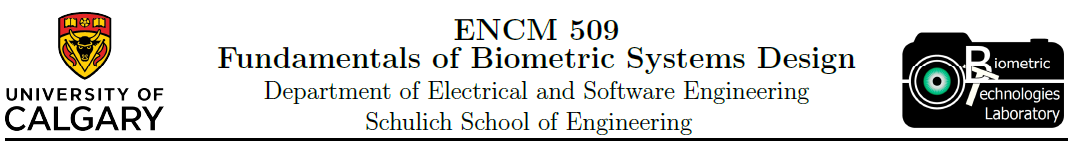

<center>
    <h1>Laboratory Experiment #6</h1>
    <h2>Face Recognition: Feature Extraction and Classification</h2>
</center>


* Team member - Abid Al Labib 
    - UCID: 30070079
* Team member - Madhu Selvaraj
    - UCID: 30061979
    

## Introduction:
In this lab we

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from utils_cm import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [107]:
# M could be large (for example, 16: 8 of yours and 8 of a friend)
# for At&T dataset there are 10 faces per subject. 
# However, we are going to load only the first 9
# the 10th image will be used to compare later on.
M =  9 #Number of images in training set

#image normalization
# can be any number that is close to the std and mean of most of the images.
um = 100
ustd = 80

Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304


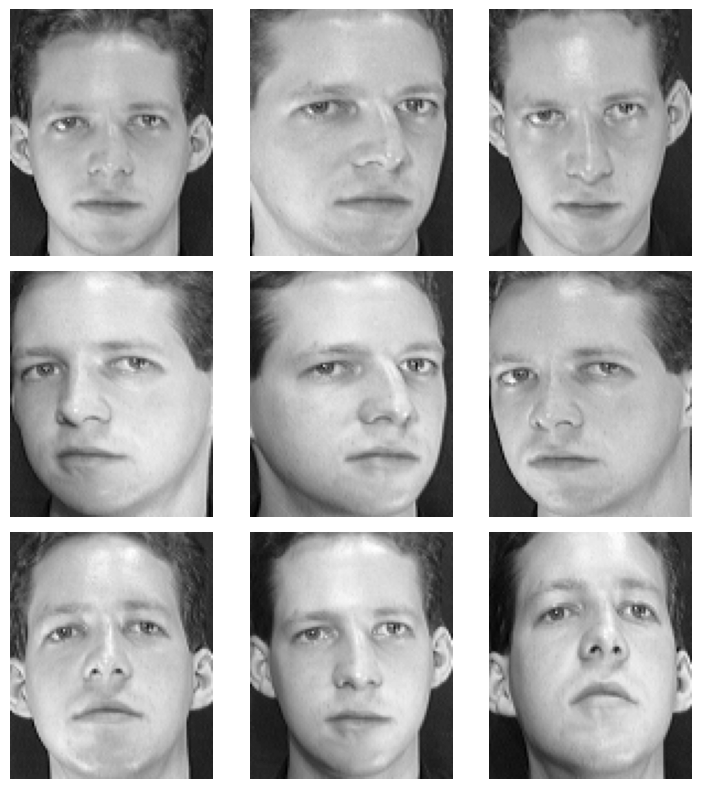

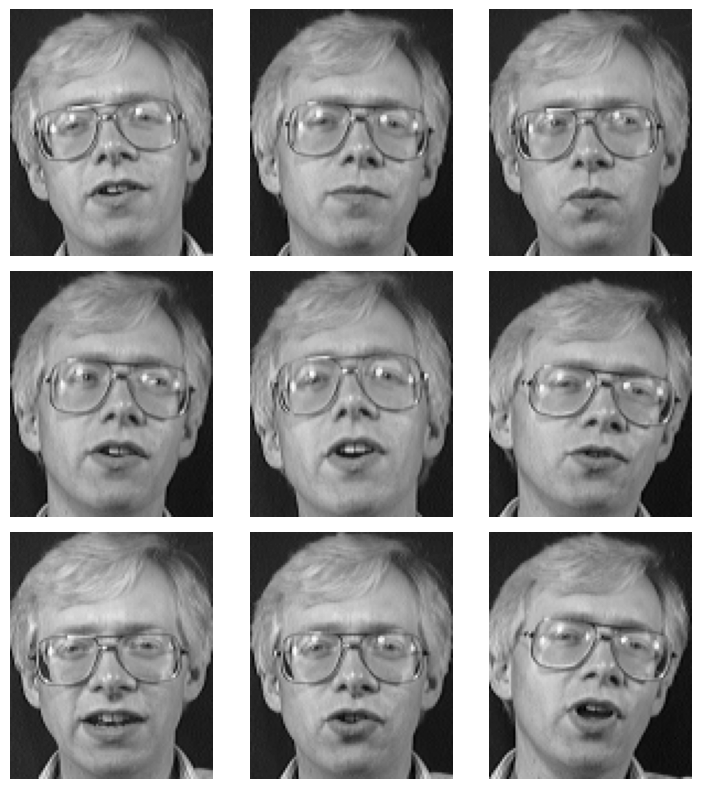

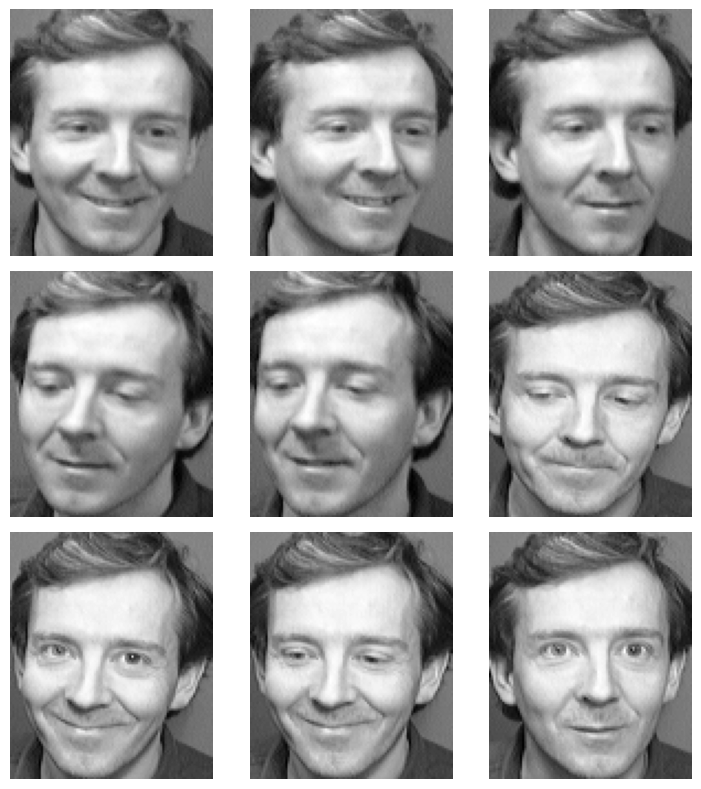

In [108]:
#loading the images
for i in range(1,4):
    path = f'ATT dataset/s{i}/'
    img = imread(path + '1.pgm', as_gray=True)

    # get the number of rows (irow) and columns (icol). 
    # these values must to be the same for all images
    irow, icol = img.shape

    # allocation of vector that will have all images
    S = np.zeros((irow*icol, M)) # img matrix

    plt.figure(figsize=(8,8))
    for i in range(1,M+1):
        img = imread(path + '{}.pgm'.format(i), as_gray=True)

        plt.subplot(3,3,i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        # reshape(img',irow*icol,1); 
        # creates a (N1*N2)x1 vector
        temp = np.reshape(img, (irow*icol,1))
        S[:,i-1] = temp[:,0] 
    # after finishing the sequence, S is a N1*N2xM matrix 

    print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304


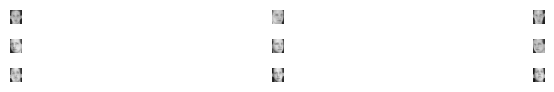

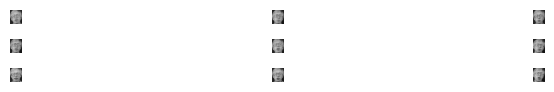

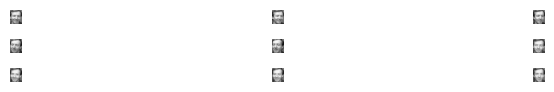

In [109]:
#storing all 27 faces into one gallery

S = np.zeros((irow*icol, M*3)) # img matrix

#loading the gallery images
for subject in range(1,4):
    path = f'ATT dataset/s{subject}/'
    img = imread(path + '1.pgm', as_gray=True)

    # get the number of rows (irow) and columns (icol). 
    # these values must to be the same for all images
    irow, icol = img.shape

    # allocation of vector that will have all images


    plt.figure(figsize=(8,8))
    for i in range(M,-1,-1):
        if i==0:
            i=i+1
        img = imread(path + '{}.pgm'.format(i), as_gray=True)

        plt.subplot(27,3,i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        # reshape(img',irow*icol,1); 
        # creates a (N1*N2)x1 vector
        temp = np.reshape(img, (irow*icol,1))
        index = (subject*9) - i
        S[:,index] = temp[:,0] 
    # after finishing the sequence, S is a N1*N2xM matrix 

    print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

##### viewing the normalized images

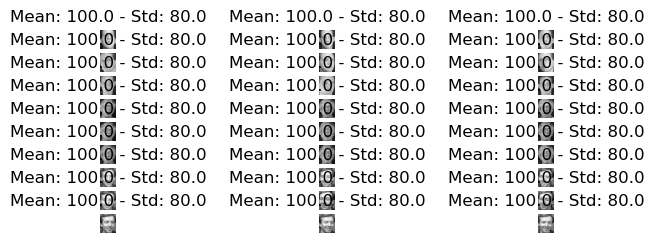

In [110]:
plt.figure(figsize=(8,8))
for i in range(27):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(27,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))

##### mean image

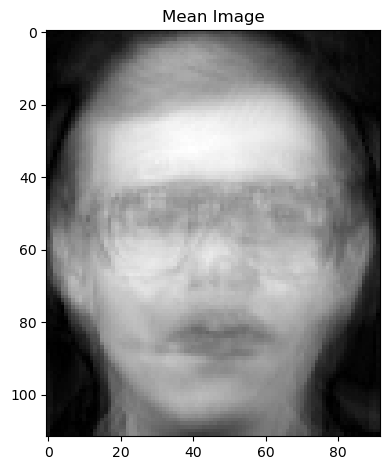

In [111]:
# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image');

##### Creating covariance matrix  L

In [112]:
dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

##### Sort and eliminate zero eigenvalue

In [113]:
v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

C:\Users\getab\AppData\Local\Temp\ipykernel_49624\184907035.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


#### Normalization of eigenvectors

In [114]:
for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

#### Showing eigenfaces

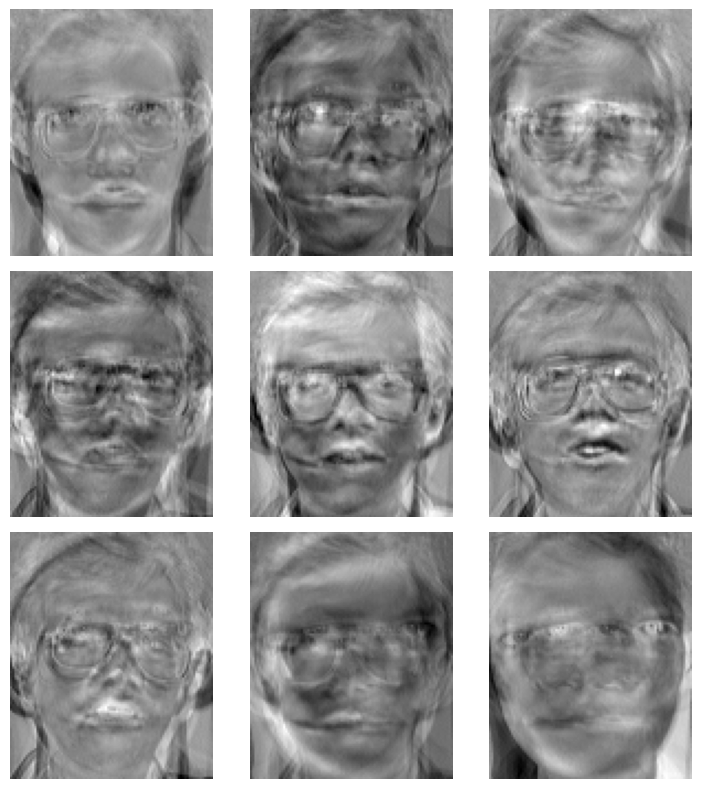

In [115]:
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

#### Find the weight of each face in the training set

In [116]:
omega = np.zeros((27,27))
WW = np.zeros((27,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

### Probe images and matching

Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304


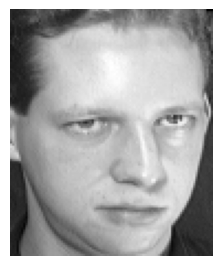

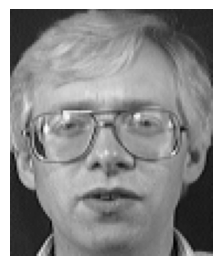

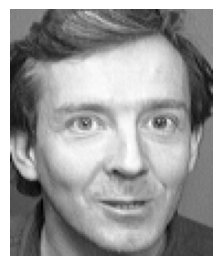

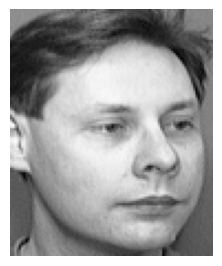

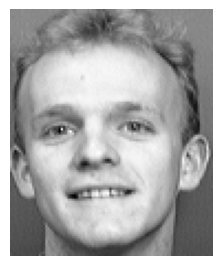

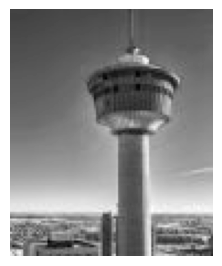

In [117]:
#probe images -> storing all together???
p = np.zeros((irow*icol, 6)) # img matrix
#loading the images
for i in range(1,6):
    path = f'ATT dataset/s{i}/'
    img = imread(path + '10.pgm', as_gray=True)

    # get the number of rows (irow) and columns (icol). 
    # these values must to be the same for all images
    irow, icol = img.shape

    # allocation of vector that will have all images
   

    plt.figure(figsize=(8,8))
    plt.subplot(3,3,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # reshape(img',irow*icol,1); 
    # creates a (N1*N2)x1 vector
    temp = np.reshape(img, (irow*icol,1))
    p[:,i-1] = temp[:,0] 

    print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

#non face images
img = imread('CalgaryTower.jpg', as_gray=True)    

irow, icol = img.shape

plt.figure(figsize=(8,8))
plt.subplot(3,3,i)
plt.imshow(img, cmap='gray')
plt.axis('off')

# reshape(img',irow*icol,1); 
# creates a (N1*N2)x1 vector
temp = np.reshape(img, (irow*icol,1))
p[:,5] = temp[:,0] 
print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))    

# looping over all the loaded images in p to normalize
for i in range(p.shape[1]):
    temp = p[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    p[:,i] = (temp - m) * ustd / st + um

## Acquisition of probe image: 10th image of each of the three subjects in the dataset

In [118]:
# using the last image of subject #1
path = './ATT dataset/s1/'
InputImage = imread(path + '10.pgm', as_gray=True)

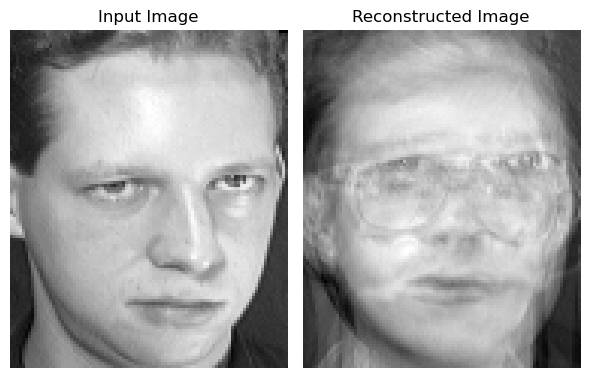

In [119]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((27,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

In [120]:
eSameSubject = np.zeros((27,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eSameSubject[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eSameSubject) 
MinimumValue = np.min(eSameSubject) 

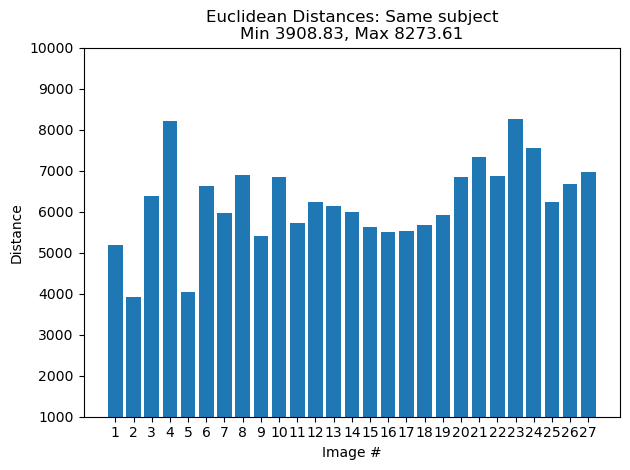

In [121]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9',
          '10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27')

plt.bar(np.arange(len(eSameSubject)), eSameSubject.flatten(), tick_label=labels)
plt.ylim([1000, 10000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

In [122]:
# using the last image of subject #2
path = './ATT dataset/s2/'
InputImage = imread(path + '10.pgm', as_gray=True)

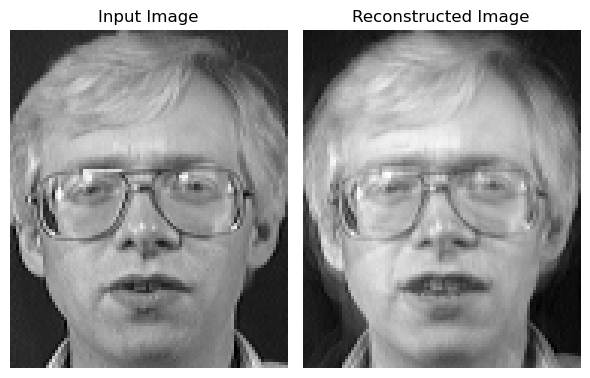

In [123]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((27,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

In [124]:
eSameSubject = np.zeros((27,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eSameSubject[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eSameSubject) 
MinimumValue = np.min(eSameSubject) 

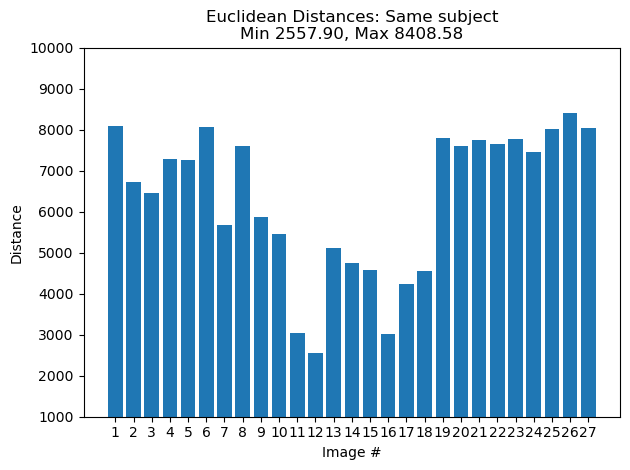

In [125]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9',
          '10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27')

plt.bar(np.arange(len(eSameSubject)), eSameSubject.flatten(), tick_label=labels)
plt.ylim([1000, 10000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

In [126]:
# using the last image of subject #1
path = './ATT dataset/s3/'
InputImage = imread(path + '10.pgm', as_gray=True)

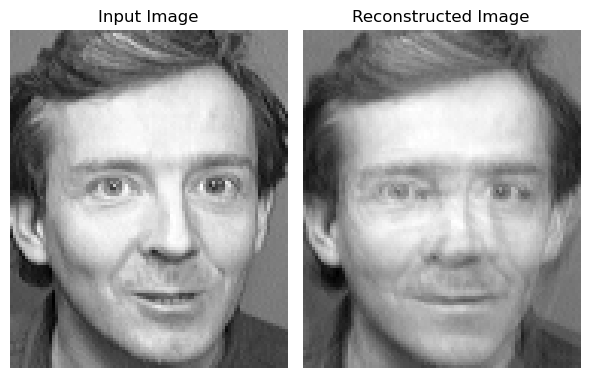

In [127]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((27,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

In [128]:
eSameSubject = np.zeros((27,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eSameSubject[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eSameSubject) 
MinimumValue = np.min(eSameSubject) 

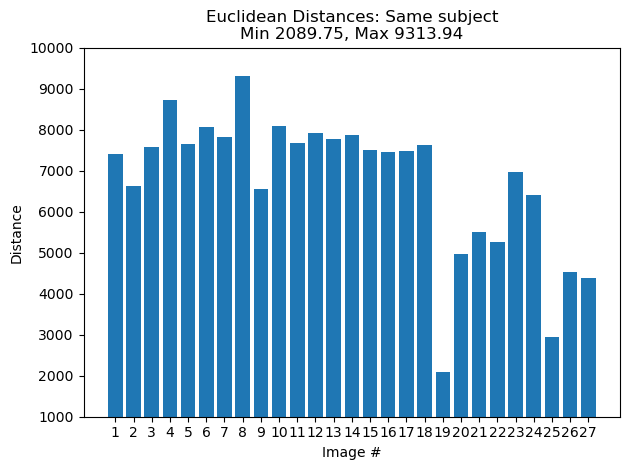

In [129]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9',
          '10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27')

plt.bar(np.arange(len(eSameSubject)), eSameSubject.flatten(), tick_label=labels)
plt.ylim([1000, 10000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

## Acquisition of probe image: 2-3 faces of the subjects not known to the dataset

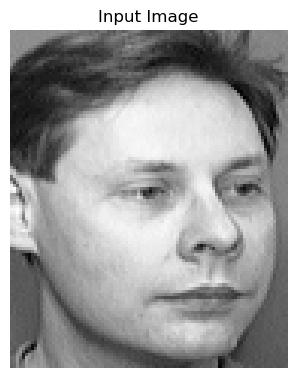

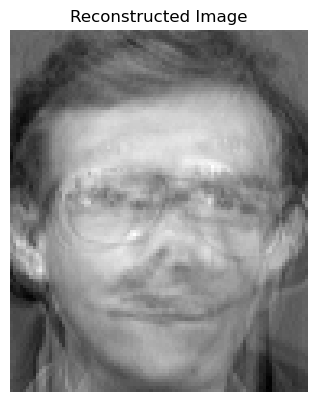

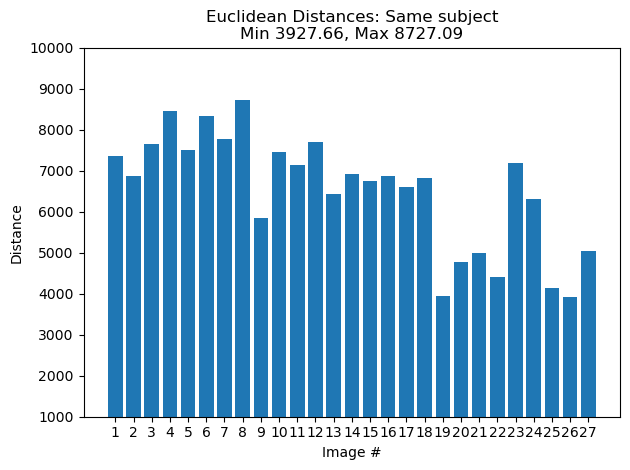

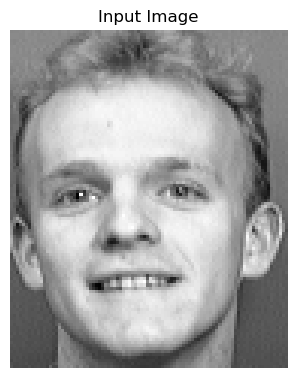

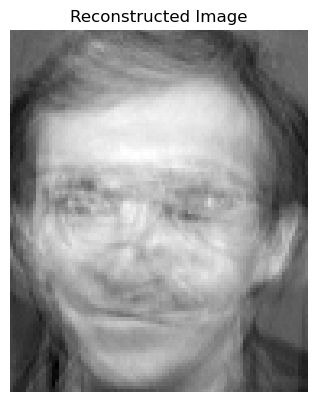

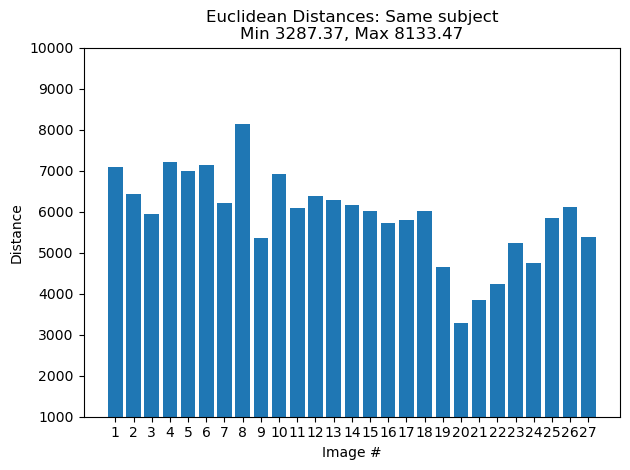

In [130]:
for i in range(4,6):
    path = f'./ATT dataset/s{i}/'
    InputImage = imread(path + '10.pgm', as_gray=True)

    plt.figure(figsize=(6,6))

    plt.subplot(1,2,1)
    plt.imshow(InputImage, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.show()
    
    InImage = np.reshape(InputImage, (irow*icol,1))

    # Normalization
    temp = InImage
    me = np.mean(temp)
    st = np.std(temp)
    temp = (temp-me) * ustd/st + um
    NormImage = temp

    # Finding Difference: NormalizedImage - MeanImage
    Difference = temp - m

    p = np.zeros((u.shape[1],1))
    for i in range(u.shape[1]):
        # dot returns scalar vector product
        pare = np.dot(u[:,i], NormImage) 
        p[i] = pare

    # m is the mean image, u is the eigenvector
    ReshapedImage = m + np.matmul(u, p) 
    ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

    # show the reconstructed image
    plt.subplot(1,2,2)
    plt.imshow(ReshapedImage, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.show()
    
    InImWeight = np.zeros((27,1))

    for i in range(u.shape[1]):
        t = u[:,i].reshape(-1,1).T
        # scalar vector product of vectors t and Difference
        WeightOfInputImage = np.dot(t, Difference) 
        InImWeight[i] = WeightOfInputImage


    eDiffSubject = np.zeros((27,1))

    for i in range(omega.shape[1]):
        q = omega[:,i].reshape(-1,1)
        DiffWeight = InImWeight - q
        mag = np.linalg.norm(DiffWeight)
        eDiffSubject[i] = mag

    # max/min Euclidean distance
    MaximumValue = np.max(eDiffSubject) 
    MinimumValue = np.min(eDiffSubject)

    eDiffSubject = np.zeros((27,1))

    for i in range(omega.shape[1]):
        q = omega[:,i].reshape(-1,1)
        DiffWeight = InImWeight - q
        mag = np.linalg.norm(DiffWeight)
        eDiffSubject[i] = mag

    # max/min Euclidean distance
    MaximumValue = np.max(eDiffSubject) 
    MinimumValue = np.min(eDiffSubject) 


    labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9',
              '10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27')

    plt.bar(np.arange(len(eDiffSubject)), eDiffSubject.flatten(), tick_label=labels)
    plt.ylim([1000, 10000])
    plt.xlabel('Image #')
    plt.ylabel('Distance')
    plt.title('Euclidean Distances: Different subject\n'\
              'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));
    
    plt.show()

## Acquisition of probe image: 1-2 Not a face image

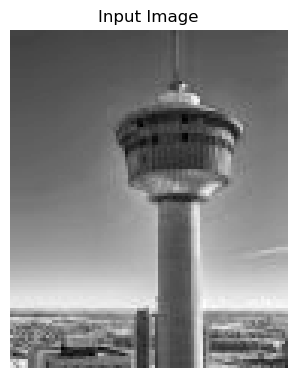

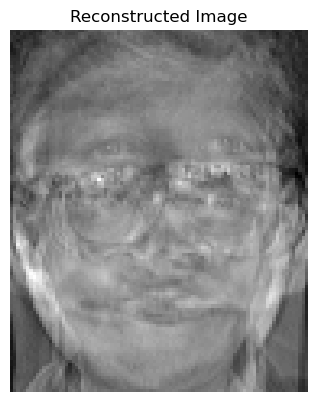

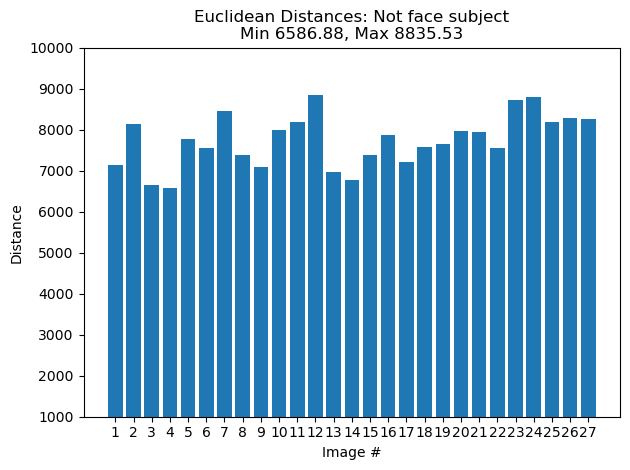

In [131]:
InputImage = imread('CalgaryTower.jpg', as_gray=True) 

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

plt.show()

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()

InImWeight = np.zeros((27,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage


eTower = np.zeros((27,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTower[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eTower) 
MinimumValue = np.min(eTower)

eTower = np.zeros((27,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTower[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eTower) 
MinimumValue = np.min(eTower) 


labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9',
          '10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27')

plt.bar(np.arange(len(eTower)), eTower.flatten(), tick_label=labels)
plt.ylim([1000, 10000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not face subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

plt.show()

In [132]:
# Set Threshold Values 
threshold1 = 9314
threshold2 = 8727

distances = eSameSubject
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')
    
distances = eDiffSubject
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')

distances = eTower
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')
       

Image is in the database
Image is in the database
Image is in the database


In [135]:
# Set Threshold Values 
threshold1 = 7000
threshold2 = 8000

print(np.mean(eSameSubject))
print(np.mean(eDiffSubject))
print(np.mean(eTower))

distances = eSameSubject
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')
    
distances = eDiffSubject
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')

distances = eTower
mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')
       

6747.374705807325
5899.401704841481
7740.298202100344
Image is in the database
Image is in the database
Image is a face but not in the database


## Exercise 3:

In [1]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

In [25]:
n_subjects = 40

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


In [26]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [27]:
print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))

Training faces: 200
Size of each sample: 10304


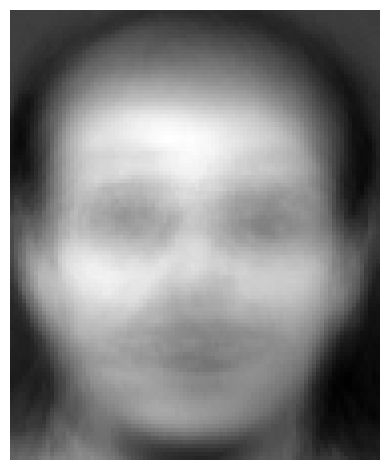

C:\Users\getab\anaconda3\envs\encm509\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 85%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


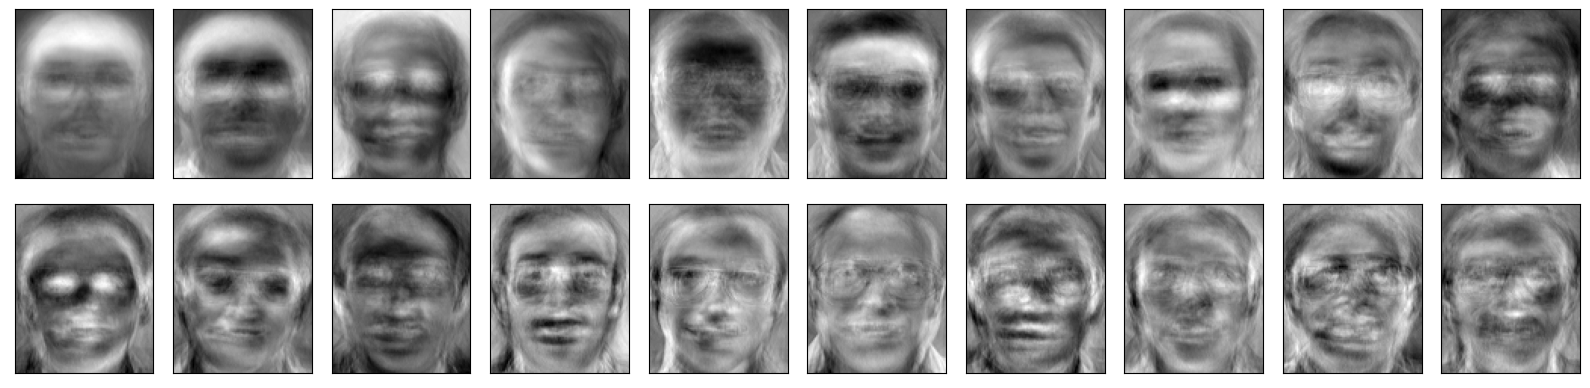

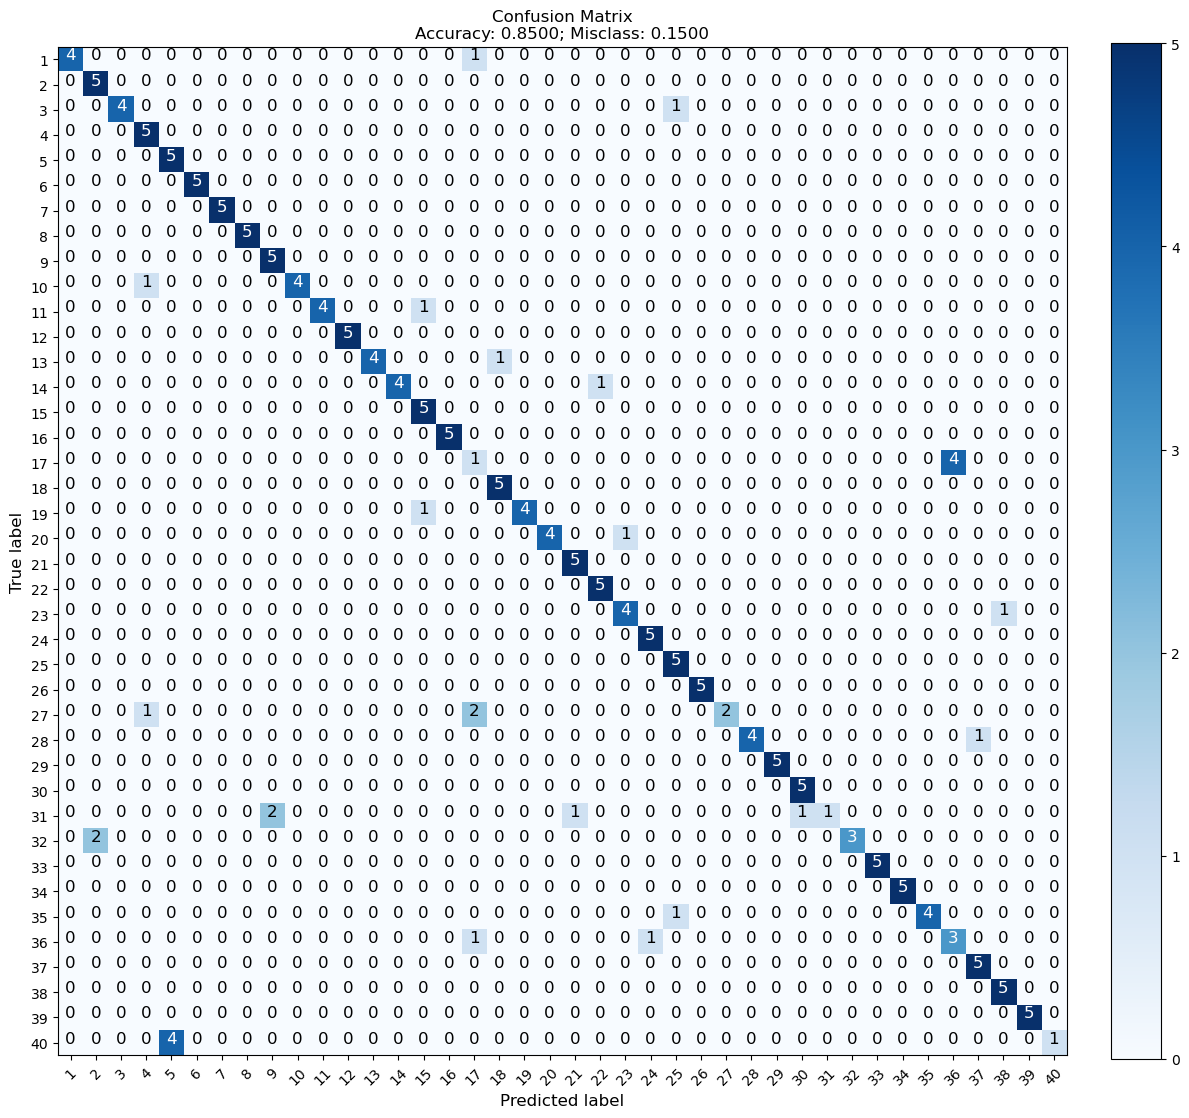

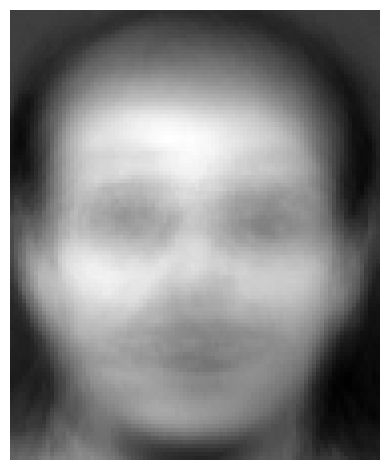

C:\Users\getab\anaconda3\envs\encm509\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


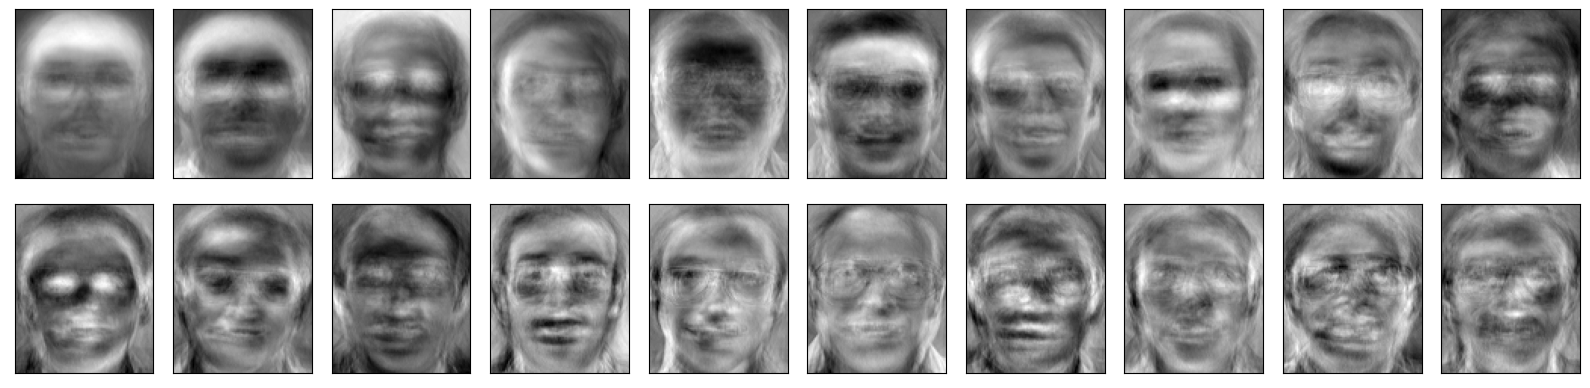

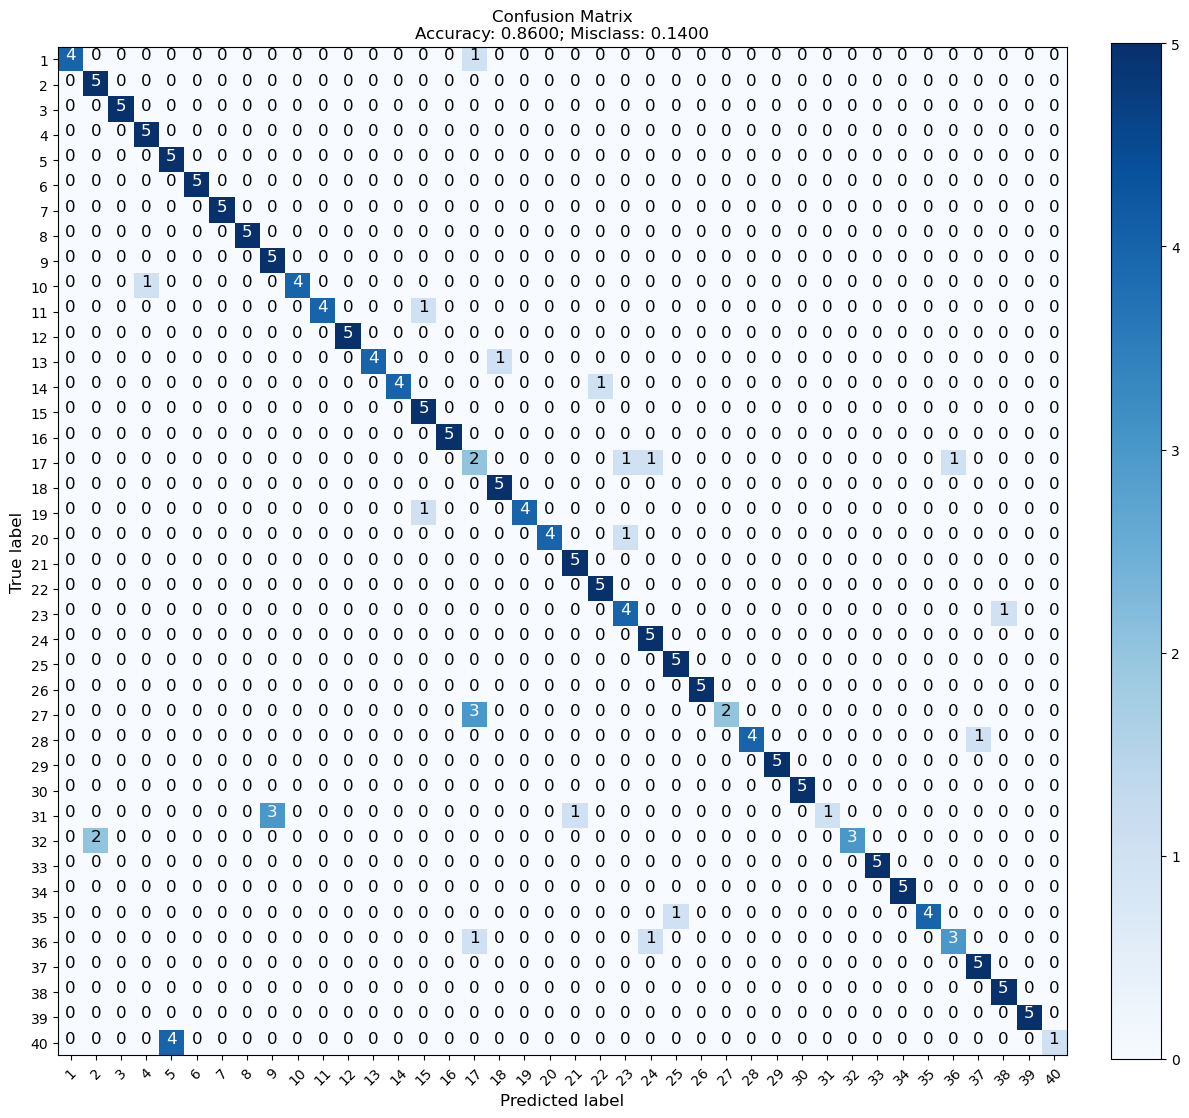

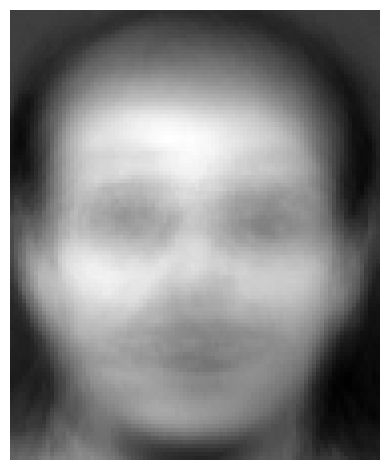

C:\Users\getab\anaconda3\envs\encm509\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


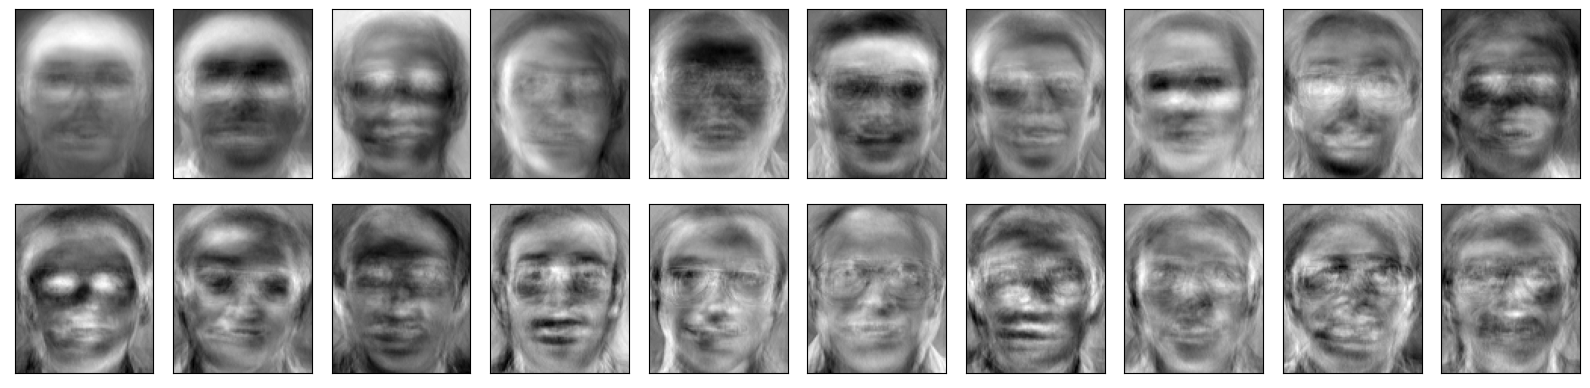

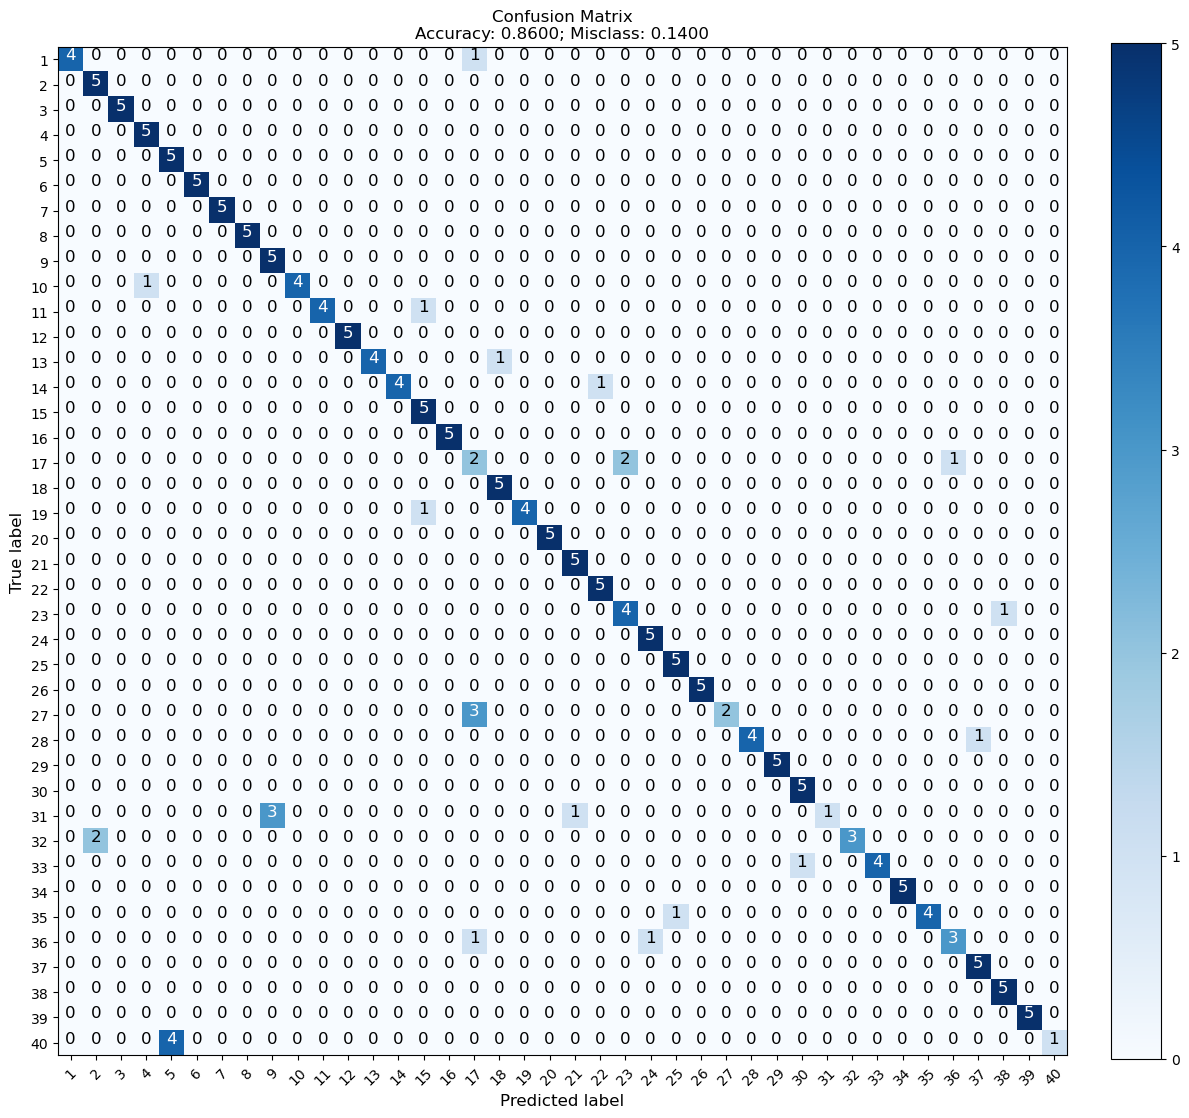

In [28]:
# n_components: number of principal components
n_components_options = [50,100,200]
for n_components_pca in n_components_options:
    pca = PCA(n_components=n_components_pca)

    # fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
    pca.fit(trainingFaces)
    train_pca = pca.transform(trainingFaces)
    test_pca = pca.transform(testingFaces)
    plt.imshow(pca.mean_.reshape(img.shape))
    plt.axis('off');
    plt.show()
    fig = plt.figure(figsize=(16, 6))
    for i in range(20):
        ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(pca.components_[i].reshape(img.shape))
    knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
    predictedLabels = knn_pca.predict(test_pca)
    prediction_evaluation(predictedLabels, testingLabels)
    # Generate the confusion matrix
    confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

    plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

## Exercise 4:

In [32]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

number of knn_neighbors=5
For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]
Training faces: 160
Size of each sample: 10304


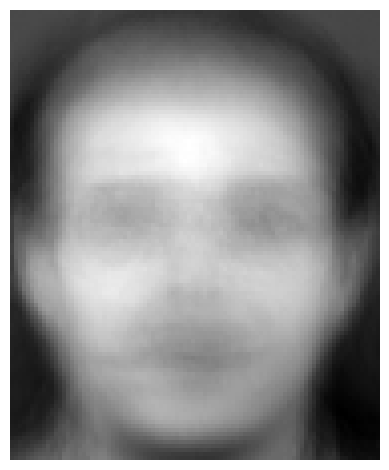

C:\Users\getab\anaconda3\envs\encm509\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 92%
Subject #1:
	TP: 2, FP: 0, TN: 38, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


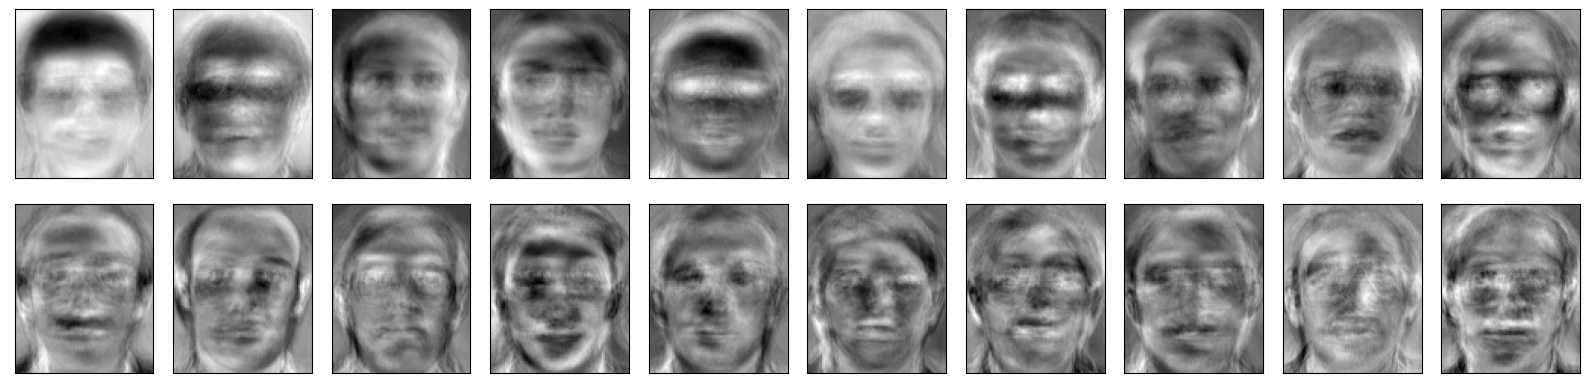

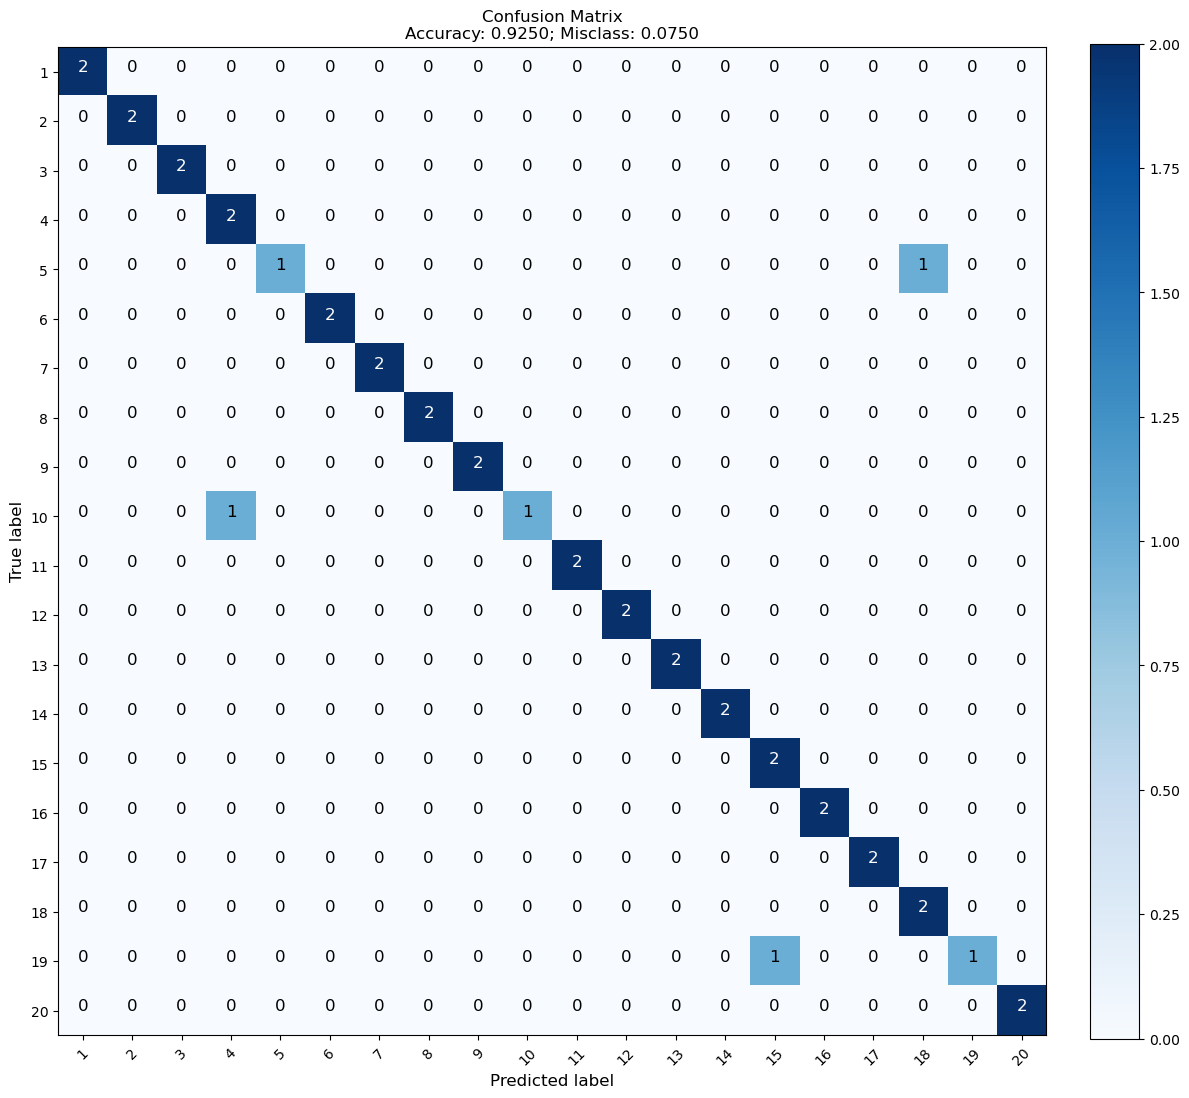

number of knn_neighbors=8
For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]
Training faces: 160
Size of each sample: 10304


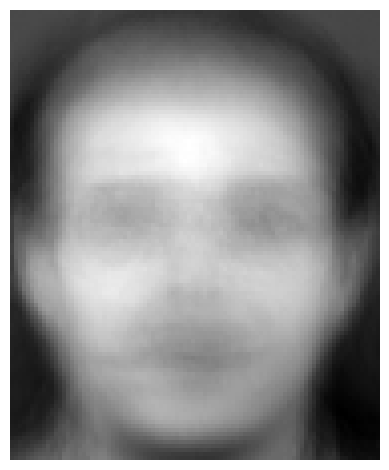

C:\Users\getab\anaconda3\envs\encm509\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Overall Accuracy: 87%
Subject #1:
	TP: 2, FP: 0, TN: 38, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


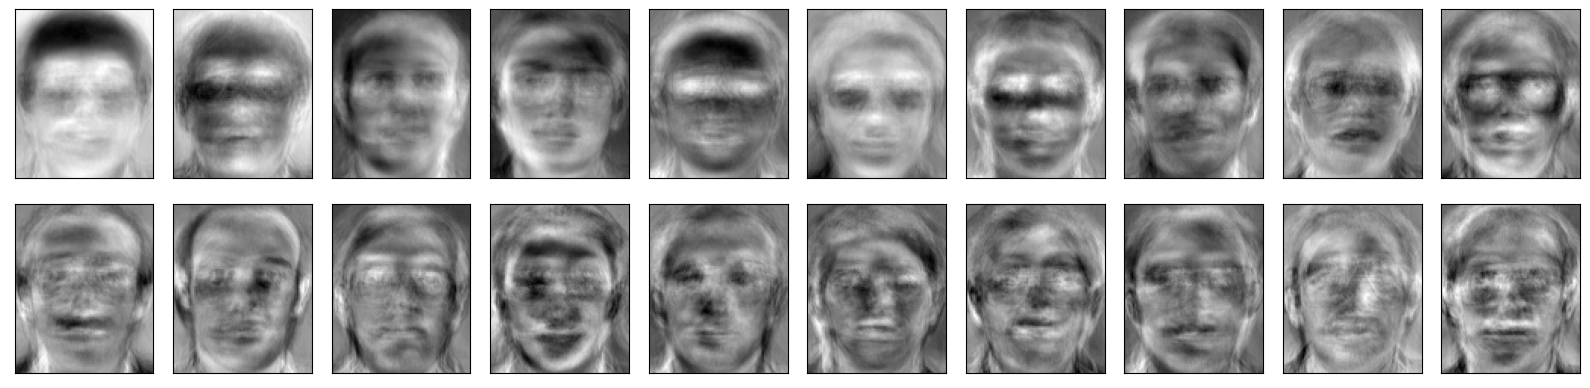

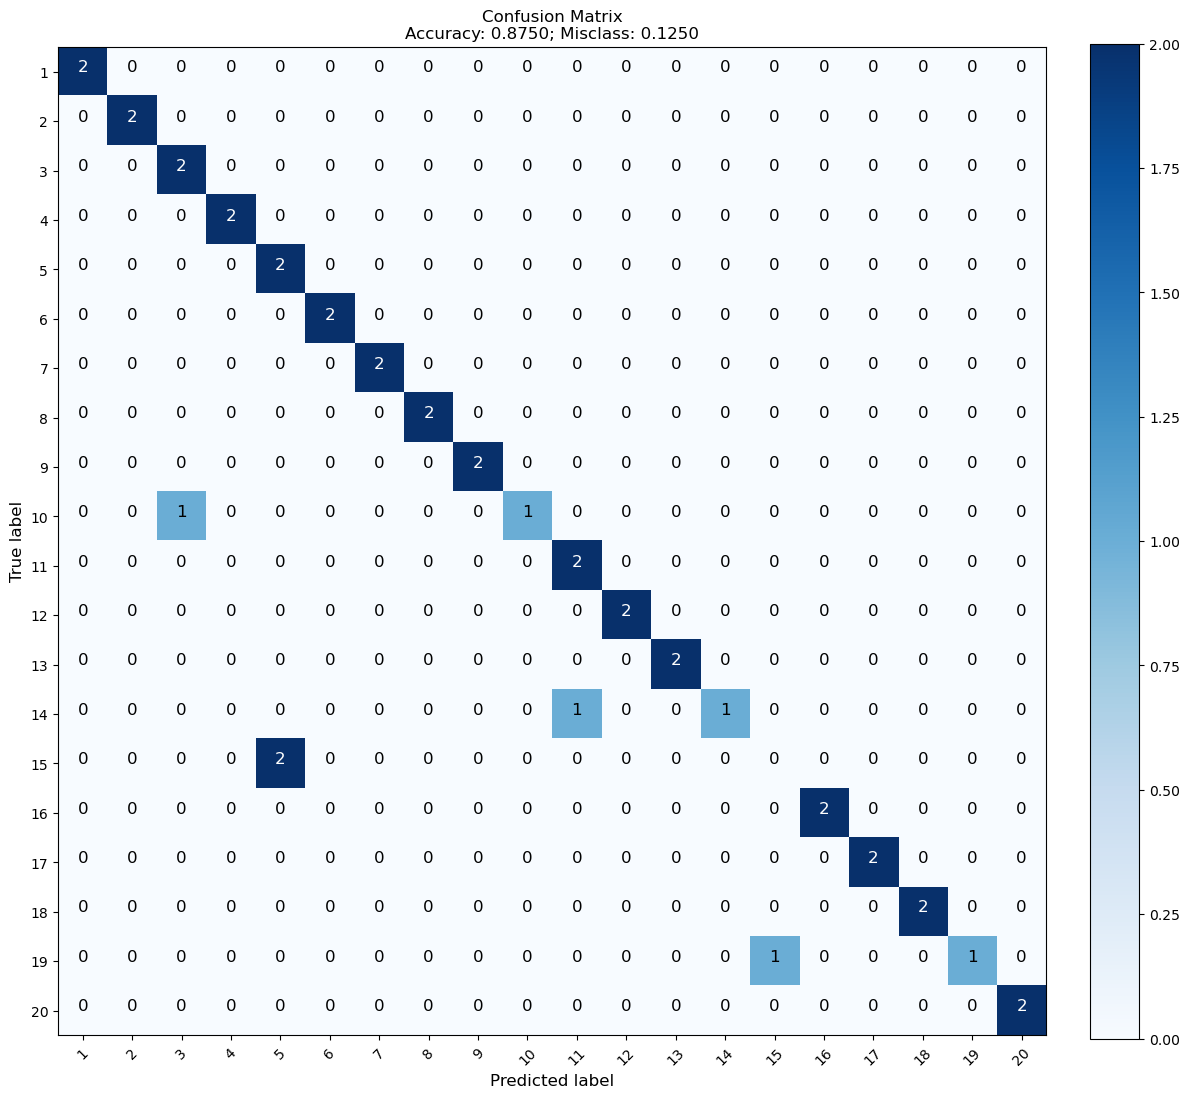

In [33]:
n_subjects = 20

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

# number of images should sum to 10
n_training_images = 8
n_test_images = 2

knn_neighbors_list = [5,8]
for knn_neighbors in knn_neighbors_list:
    print(f"number of knn_neighbors={knn_neighbors}")
    print('For EACH of all the %d subjects:' % (n_subjects))
    print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
    print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])
    
    # use the first 5 images from subjectID 1-n_subjects to train the classifier
    trainingFaces = []
    trainingLabels = []
    for subjectId in range(1, n_subjects+1):
        for imageId in range(1, n_training_images+1):
            img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
            trainingFaces.append(np.reshape(img, (img.size,)))
            trainingLabels.append(subjectId)

    # use the last 5 images from subjectID 1-20 to test the classifier
    testingFaces = []
    testingLabels = []
    for subjectId in range(1, n_subjects+1):
        for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
            img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
            testingFaces.append(np.reshape(img, (img.size,)))
            testingLabels.append(subjectId)
            
    print('Training faces:', len(trainingFaces))
    print('Size of each sample:', len(trainingFaces[0]))  
    # n_components: number of principal components
    n_components_pca = 100
    pca = PCA(n_components=n_components_pca)

    # fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
    pca.fit(trainingFaces)
    train_pca = pca.transform(trainingFaces)
    test_pca = pca.transform(testingFaces)
    plt.imshow(pca.mean_.reshape(img.shape))
    plt.axis('off');
    plt.show()
    fig = plt.figure(figsize=(16, 6))
    for i in range(20):
        ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(pca.components_[i].reshape(img.shape))
    knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
    predictedLabels = knn_pca.predict(test_pca)
    prediction_evaluation(predictedLabels, testingLabels)
    # Generate the confusion matrix
    confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

    plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])